This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set the path to the data
mean_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/mean_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
mean_aggregated_data_pca = pd.read_parquet(mean_aggregated_data_pca_path)
print(mean_aggregated_data_pca.shape)
mean_aggregated_data_pca.head()

(83, 86)


,Metadata_genotype,Metadata_replicate,Metadata_side,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
0,High-Severity,1,L,-7.710260,-4.264421,1.521397,-1.390342,9.410620,-6.054486,1.336078,...,0.213169,0.034717,0.129185,-0.146640,-0.081667,-0.075119,-0.020639,0.058634,0.028028,9.906943e-16
1,High-Severity,1,R,0.695800,8.170808,-1.217780,-2.386591,-2.609680,1.468471,4.371038,...,-0.215559,-0.068413,-0.266401,-0.023500,-0.054200,-0.023511,0.119934,0.145838,0.035305,-8.556710e-17
2,High-Severity,10,L,6.910961,11.252120,-2.831527,-3.131419,-2.634531,3.551757,-2.684211,...,-0.075988,-0.123323,-0.210824,0.063699,0.148910,0.041040,0.020007,0.161693,-0.143457,-4.445563e-16
3,High-Severity,10,R,2.179877,6.184598,-3.463740,-0.260566,-3.067898,1.597567,2.061996,...,0.416289,0.348893,0.151410,0.326023,-0.207744,0.234788,-0.024102,-0.150510,0.049366,3.319675e-17
4,High-Severity,11,L,1.336690,9.305025,3.279230,0.938479,6.459164,-4.944010,-1.393619,...,-0.028287,0.092703,0.038004,0.095451,0.043627,0.006402,-0.030578,-0.017234,0.008486,-1.129520e-15


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA 
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = mean_aggregated_data_pca[
    mean_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = mean_aggregated_data_pca[
    mean_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = mean_aggregated_data_pca[
    mean_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

28 27 28


In [4]:
# drop the the Metadata columns
metadata_columns = high_severity.columns[high_severity.columns.str.contains("Metadata")]
high_severity = high_severity.drop(metadata_columns, axis=1)
low_severity = low_severity.drop(metadata_columns, axis=1)
wt = wt.drop(metadata_columns, axis=1)


# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(28, 83) (27, 83) (28, 83)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 11.762056342410409


/home/lippincm/miniforge3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 13.336934733749693


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 10.91427607576582


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                            | 0/1000 [00:00<?, ?it/s]

  0%|                                                    | 1/1000 [00:00<03:02,  5.48it/s]

  0%|                                                    | 2/1000 [00:00<07:00,  2.37it/s]

  0%|▏                                                   | 3/1000 [00:01<10:34,  1.57it/s]

  0%|▏                                                   | 4/1000 [00:02<12:02,  1.38it/s]

  0%|▎                                                   | 5/1000 [00:03<10:52,  1.52it/s]

  1%|▎                                                   | 6/1000 [00:03<11:52,  1.40it/s]

  1%|▎                                                   | 7/1000 [00:04<13:23,  1.24it/s]

  1%|▍                                                   | 8/1000 [00:05<11:33,  1.43it/s]

  1%|▍                                                   | 9/1000 [00:05<09:33,  1.73it/s]

  1%|▌                                                  | 10/1000 [00:06<08:55,  1.85it/s]

  1%|▌                                                  | 11/1000 [00:06<07:06,  2.32it/s]

  1%|▌                                                  | 12/1000 [00:06<05:50,  2.82it/s]

  1%|▋                                                  | 13/1000 [00:06<05:07,  3.21it/s]

  1%|▋                                                  | 14/1000 [00:07<07:30,  2.19it/s]

  2%|▊                                                  | 15/1000 [00:07<06:48,  2.41it/s]

  2%|▊                                                  | 16/1000 [00:08<06:08,  2.67it/s]

  2%|▊                                                  | 17/1000 [00:08<05:18,  3.09it/s]

  2%|▉                                                  | 18/1000 [00:09<07:42,  2.12it/s]

  2%|▉                                                  | 19/1000 [00:10<09:45,  1.68it/s]

  2%|█                                                  | 20/1000 [00:10<08:42,  1.87it/s]

  2%|█                                                  | 21/1000 [00:10<08:39,  1.88it/s]

  2%|█                                                  | 22/1000 [00:11<07:58,  2.04it/s]

  2%|█▏                                                 | 23/1000 [00:11<07:32,  2.16it/s]

  2%|█▏                                                 | 24/1000 [00:12<10:04,  1.61it/s]

  2%|█▎                                                 | 25/1000 [00:12<08:17,  1.96it/s]

  3%|█▎                                                 | 26/1000 [00:13<09:03,  1.79it/s]

  3%|█▍                                                 | 27/1000 [00:15<13:13,  1.23it/s]

  3%|█▍                                                 | 28/1000 [00:15<10:30,  1.54it/s]

  3%|█▍                                                 | 29/1000 [00:15<08:11,  1.98it/s]

  3%|█▌                                                 | 30/1000 [00:15<08:13,  1.96it/s]

  3%|█▌                                                 | 31/1000 [00:17<11:30,  1.40it/s]

  3%|█▋                                                 | 32/1000 [00:18<12:44,  1.27it/s]

  3%|█▋                                                 | 33/1000 [00:18<12:03,  1.34it/s]

  3%|█▋                                                 | 34/1000 [00:19<11:22,  1.42it/s]

  4%|█▊                                                 | 35/1000 [00:19<09:24,  1.71it/s]

  4%|█▊                                                 | 36/1000 [00:20<09:53,  1.62it/s]

  4%|█▉                                                 | 37/1000 [00:21<11:11,  1.44it/s]

  4%|█▉                                                 | 38/1000 [00:22<12:33,  1.28it/s]

  4%|█▉                                                 | 39/1000 [00:23<12:56,  1.24it/s]

  4%|██                                                 | 40/1000 [00:23<13:10,  1.21it/s]

  4%|██                                                 | 41/1000 [00:24<10:02,  1.59it/s]

  4%|██▏                                                | 42/1000 [00:24<09:43,  1.64it/s]

  4%|██▏                                                | 43/1000 [00:25<08:42,  1.83it/s]

  4%|██▏                                                | 44/1000 [00:25<07:14,  2.20it/s]

  4%|██▎                                                | 45/1000 [00:25<06:29,  2.45it/s]

  5%|██▎                                                | 46/1000 [00:26<08:48,  1.81it/s]

  5%|██▍                                                | 47/1000 [00:27<10:20,  1.54it/s]

  5%|██▍                                                | 48/1000 [00:27<08:14,  1.92it/s]

  5%|██▍                                                | 49/1000 [00:27<06:38,  2.39it/s]

  5%|██▌                                                | 50/1000 [00:28<07:11,  2.20it/s]

  5%|██▌                                                | 51/1000 [00:29<09:31,  1.66it/s]

  5%|██▋                                                | 52/1000 [00:30<10:36,  1.49it/s]

  5%|██▋                                                | 53/1000 [00:30<08:44,  1.81it/s]

  5%|██▊                                                | 54/1000 [00:30<06:55,  2.27it/s]

  6%|██▊                                                | 55/1000 [00:30<05:58,  2.64it/s]

  6%|██▊                                                | 56/1000 [00:31<06:37,  2.37it/s]

  6%|██▉                                                | 57/1000 [00:32<08:03,  1.95it/s]

  6%|██▉                                                | 58/1000 [00:33<11:14,  1.40it/s]

  6%|███                                                | 59/1000 [00:33<09:52,  1.59it/s]

  6%|███                                                | 60/1000 [00:34<10:24,  1.50it/s]

  6%|███                                                | 61/1000 [00:35<10:47,  1.45it/s]

  6%|███▏                                               | 62/1000 [00:35<10:15,  1.52it/s]

  6%|███▏                                               | 63/1000 [00:36<12:41,  1.23it/s]

  6%|███▎                                               | 64/1000 [00:37<09:38,  1.62it/s]

  6%|███▎                                               | 65/1000 [00:37<07:45,  2.01it/s]

  7%|███▎                                               | 66/1000 [00:37<07:24,  2.10it/s]

  7%|███▍                                               | 67/1000 [00:38<08:28,  1.83it/s]

  7%|███▍                                               | 68/1000 [00:39<12:29,  1.24it/s]

  7%|███▌                                               | 69/1000 [00:40<13:47,  1.13it/s]

  7%|███▌                                               | 70/1000 [00:41<10:50,  1.43it/s]

  7%|███▌                                               | 71/1000 [00:41<08:25,  1.84it/s]

  7%|███▋                                               | 72/1000 [00:41<07:40,  2.01it/s]

  7%|███▋                                               | 73/1000 [00:43<11:59,  1.29it/s]

  7%|███▊                                               | 74/1000 [00:43<10:30,  1.47it/s]

  8%|███▊                                               | 75/1000 [00:44<10:32,  1.46it/s]

  8%|███▉                                               | 76/1000 [00:44<08:10,  1.88it/s]

  8%|███▉                                               | 77/1000 [00:45<08:17,  1.85it/s]

  8%|███▉                                               | 78/1000 [00:46<10:48,  1.42it/s]

  8%|████                                               | 79/1000 [00:46<10:58,  1.40it/s]

  8%|████                                               | 80/1000 [00:47<09:19,  1.64it/s]

  8%|████▏                                              | 81/1000 [00:47<08:16,  1.85it/s]

  8%|████▏                                              | 82/1000 [00:48<07:20,  2.09it/s]

  8%|████▏                                              | 83/1000 [00:48<05:55,  2.58it/s]

  8%|████▎                                              | 84/1000 [00:48<06:47,  2.25it/s]

  8%|████▎                                              | 85/1000 [00:49<07:09,  2.13it/s]

  9%|████▍                                              | 86/1000 [00:49<08:15,  1.84it/s]

  9%|████▍                                              | 87/1000 [00:50<09:28,  1.61it/s]

  9%|████▍                                              | 88/1000 [00:51<09:58,  1.52it/s]

  9%|████▌                                              | 89/1000 [00:51<08:33,  1.77it/s]

  9%|████▌                                              | 90/1000 [00:52<07:07,  2.13it/s]

  9%|████▋                                              | 91/1000 [00:52<08:22,  1.81it/s]

  9%|████▋                                              | 92/1000 [00:53<08:25,  1.80it/s]

  9%|████▋                                              | 93/1000 [00:53<07:58,  1.89it/s]

  9%|████▊                                              | 94/1000 [00:54<07:11,  2.10it/s]

 10%|████▊                                              | 95/1000 [00:54<06:13,  2.42it/s]

 10%|████▉                                              | 96/1000 [00:55<06:44,  2.24it/s]

 10%|████▉                                              | 97/1000 [00:55<05:29,  2.74it/s]

 10%|████▉                                              | 98/1000 [00:55<06:52,  2.19it/s]

 10%|█████                                              | 99/1000 [00:56<06:48,  2.21it/s]

 10%|█████                                             | 100/1000 [00:57<08:13,  1.83it/s]

 10%|█████                                             | 101/1000 [00:57<08:07,  1.84it/s]

 10%|█████                                             | 102/1000 [00:57<07:13,  2.07it/s]

 10%|█████▏                                            | 103/1000 [00:58<07:40,  1.95it/s]

 10%|█████▏                                            | 104/1000 [00:59<08:14,  1.81it/s]

 10%|█████▎                                            | 105/1000 [01:00<09:38,  1.55it/s]

 11%|█████▎                                            | 106/1000 [01:00<10:33,  1.41it/s]

 11%|█████▎                                            | 107/1000 [01:01<08:52,  1.68it/s]

 11%|█████▍                                            | 108/1000 [01:01<08:16,  1.80it/s]

 11%|█████▍                                            | 109/1000 [01:02<07:40,  1.94it/s]

 11%|█████▌                                            | 110/1000 [01:02<08:26,  1.76it/s]

 11%|█████▌                                            | 111/1000 [01:03<09:53,  1.50it/s]

 11%|█████▌                                            | 112/1000 [01:04<09:46,  1.51it/s]

 11%|█████▋                                            | 113/1000 [01:04<07:36,  1.94it/s]

 11%|█████▋                                            | 114/1000 [01:04<06:13,  2.37it/s]

 12%|█████▊                                            | 115/1000 [01:05<06:29,  2.27it/s]

 12%|█████▊                                            | 116/1000 [01:05<07:07,  2.07it/s]

 12%|█████▊                                            | 117/1000 [01:06<07:48,  1.88it/s]

 12%|█████▉                                            | 118/1000 [01:06<07:23,  1.99it/s]

 12%|█████▉                                            | 119/1000 [01:07<06:52,  2.14it/s]

 12%|██████                                            | 120/1000 [01:07<07:38,  1.92it/s]

 12%|██████                                            | 121/1000 [01:08<07:58,  1.84it/s]

 12%|██████                                            | 122/1000 [01:08<06:45,  2.17it/s]

 12%|██████▏                                           | 123/1000 [01:09<07:55,  1.84it/s]

 12%|██████▏                                           | 124/1000 [01:10<07:53,  1.85it/s]

 12%|██████▎                                           | 125/1000 [01:10<08:47,  1.66it/s]

 13%|██████▎                                           | 126/1000 [01:11<08:06,  1.79it/s]

 13%|██████▎                                           | 127/1000 [01:11<08:05,  1.80it/s]

 13%|██████▍                                           | 128/1000 [01:12<07:19,  1.98it/s]

 13%|██████▍                                           | 129/1000 [01:12<05:54,  2.46it/s]

 13%|██████▌                                           | 130/1000 [01:12<06:21,  2.28it/s]

 13%|██████▌                                           | 131/1000 [01:13<08:27,  1.71it/s]

 13%|██████▌                                           | 132/1000 [01:15<10:59,  1.32it/s]

 13%|██████▋                                           | 133/1000 [01:15<10:16,  1.41it/s]

 13%|██████▋                                           | 134/1000 [01:15<08:44,  1.65it/s]

 14%|██████▊                                           | 135/1000 [01:16<08:25,  1.71it/s]

 14%|██████▊                                           | 136/1000 [01:17<09:46,  1.47it/s]

 14%|██████▊                                           | 137/1000 [01:18<10:34,  1.36it/s]

 14%|██████▉                                           | 138/1000 [01:19<10:37,  1.35it/s]

 14%|██████▉                                           | 139/1000 [01:19<08:24,  1.71it/s]

 14%|███████                                           | 140/1000 [01:19<06:51,  2.09it/s]

 14%|███████                                           | 141/1000 [01:19<05:57,  2.40it/s]

 14%|███████                                           | 142/1000 [01:19<05:00,  2.85it/s]

 14%|███████▏                                          | 143/1000 [01:20<04:22,  3.26it/s]

 14%|███████▏                                          | 144/1000 [01:20<03:55,  3.64it/s]

 14%|███████▏                                          | 145/1000 [01:20<03:48,  3.75it/s]

 15%|███████▎                                          | 146/1000 [01:20<03:29,  4.08it/s]

 15%|███████▎                                          | 147/1000 [01:21<03:31,  4.03it/s]

 15%|███████▍                                          | 148/1000 [01:21<03:29,  4.07it/s]

 15%|███████▍                                          | 149/1000 [01:21<03:08,  4.52it/s]

 15%|███████▌                                          | 150/1000 [01:21<02:55,  4.85it/s]

 15%|███████▌                                          | 151/1000 [01:21<02:47,  5.06it/s]

 15%|███████▌                                          | 152/1000 [01:22<02:53,  4.89it/s]

 15%|███████▋                                          | 153/1000 [01:22<02:45,  5.12it/s]

 15%|███████▋                                          | 154/1000 [01:22<02:39,  5.31it/s]

 16%|███████▊                                          | 155/1000 [01:22<02:51,  4.93it/s]

 16%|███████▊                                          | 156/1000 [01:22<02:44,  5.13it/s]

 16%|███████▊                                          | 157/1000 [01:22<02:38,  5.31it/s]

 16%|███████▉                                          | 158/1000 [01:23<02:34,  5.45it/s]

 16%|███████▉                                          | 159/1000 [01:23<02:50,  4.92it/s]

 16%|████████                                          | 160/1000 [01:23<02:43,  5.14it/s]

 16%|████████                                          | 161/1000 [01:23<02:37,  5.33it/s]

 16%|████████                                          | 162/1000 [01:23<02:33,  5.47it/s]

 16%|████████▏                                         | 163/1000 [01:24<02:30,  5.56it/s]

 16%|████████▏                                         | 164/1000 [01:24<02:47,  4.99it/s]

 16%|████████▎                                         | 165/1000 [01:24<02:57,  4.69it/s]

 17%|████████▎                                         | 166/1000 [01:24<03:01,  4.59it/s]

 17%|████████▎                                         | 167/1000 [01:25<03:33,  3.90it/s]

 17%|████████▍                                         | 168/1000 [01:25<03:27,  4.01it/s]

 17%|████████▍                                         | 169/1000 [01:25<03:08,  4.40it/s]

 17%|████████▌                                         | 170/1000 [01:25<02:55,  4.74it/s]

 17%|████████▌                                         | 171/1000 [01:25<02:45,  5.01it/s]

 17%|████████▌                                         | 172/1000 [01:26<03:12,  4.30it/s]

 17%|████████▋                                         | 173/1000 [01:26<03:23,  4.07it/s]

 17%|████████▋                                         | 174/1000 [01:26<03:33,  3.87it/s]

 18%|████████▊                                         | 175/1000 [01:27<03:37,  3.79it/s]

 18%|████████▊                                         | 176/1000 [01:27<03:39,  3.76it/s]

 18%|████████▊                                         | 177/1000 [01:27<03:48,  3.60it/s]

 18%|████████▉                                         | 178/1000 [01:27<03:30,  3.90it/s]

 18%|████████▉                                         | 179/1000 [01:28<03:25,  3.99it/s]

 18%|█████████                                         | 180/1000 [01:28<03:26,  3.97it/s]

 18%|█████████                                         | 181/1000 [01:28<03:33,  3.83it/s]

 18%|█████████                                         | 182/1000 [01:28<03:46,  3.62it/s]

 18%|█████████▏                                        | 183/1000 [01:29<03:20,  4.07it/s]

 18%|█████████▏                                        | 184/1000 [01:29<03:19,  4.08it/s]

 18%|█████████▎                                        | 185/1000 [01:29<03:19,  4.09it/s]

 19%|█████████▎                                        | 186/1000 [01:29<03:10,  4.27it/s]

 19%|█████████▎                                        | 187/1000 [01:29<03:08,  4.31it/s]

 19%|█████████▍                                        | 188/1000 [01:30<03:24,  3.97it/s]

 19%|█████████▍                                        | 189/1000 [01:30<03:29,  3.86it/s]

 19%|█████████▌                                        | 190/1000 [01:30<03:39,  3.68it/s]

 19%|█████████▌                                        | 191/1000 [01:31<03:38,  3.71it/s]

 19%|█████████▌                                        | 192/1000 [01:31<03:16,  4.12it/s]

 19%|█████████▋                                        | 193/1000 [01:31<03:23,  3.97it/s]

 19%|█████████▋                                        | 194/1000 [01:31<03:25,  3.93it/s]

 20%|█████████▊                                        | 195/1000 [01:32<03:05,  4.34it/s]

 20%|█████████▊                                        | 196/1000 [01:32<03:11,  4.19it/s]

 20%|█████████▊                                        | 197/1000 [01:32<02:55,  4.57it/s]

 20%|█████████▉                                        | 198/1000 [01:32<03:07,  4.28it/s]

 20%|█████████▉                                        | 199/1000 [01:32<02:52,  4.64it/s]

 20%|██████████                                        | 200/1000 [01:33<02:59,  4.46it/s]

 20%|██████████                                        | 201/1000 [01:33<03:37,  3.68it/s]

 20%|██████████                                        | 202/1000 [01:33<03:13,  4.13it/s]

 20%|██████████▏                                       | 203/1000 [01:33<02:56,  4.51it/s]

 20%|██████████▏                                       | 204/1000 [01:34<02:59,  4.44it/s]

 20%|██████████▎                                       | 205/1000 [01:34<03:04,  4.31it/s]

 21%|██████████▎                                       | 206/1000 [01:34<02:50,  4.67it/s]

 21%|██████████▎                                       | 207/1000 [01:34<02:39,  4.96it/s]

 21%|██████████▍                                       | 208/1000 [01:35<03:07,  4.22it/s]

 21%|██████████▍                                       | 209/1000 [01:35<02:53,  4.56it/s]

 21%|██████████▌                                       | 210/1000 [01:35<02:57,  4.46it/s]

 21%|██████████▌                                       | 211/1000 [01:35<02:57,  4.45it/s]

 21%|██████████▌                                       | 212/1000 [01:35<02:57,  4.44it/s]

 21%|██████████▋                                       | 213/1000 [01:36<02:47,  4.71it/s]

 21%|██████████▋                                       | 214/1000 [01:36<02:37,  4.99it/s]

 22%|██████████▊                                       | 215/1000 [01:36<02:30,  5.21it/s]

 22%|██████████▊                                       | 216/1000 [01:36<02:40,  4.88it/s]

 22%|██████████▊                                       | 217/1000 [01:36<02:32,  5.13it/s]

 22%|██████████▉                                       | 218/1000 [01:36<02:27,  5.31it/s]

 22%|██████████▉                                       | 219/1000 [01:37<02:23,  5.43it/s]

 22%|███████████                                       | 220/1000 [01:37<02:21,  5.53it/s]

 22%|███████████                                       | 221/1000 [01:37<02:18,  5.61it/s]

 22%|███████████                                       | 222/1000 [01:37<02:33,  5.06it/s]

 22%|███████████▏                                      | 223/1000 [01:37<02:45,  4.69it/s]

 22%|███████████▏                                      | 224/1000 [01:38<02:50,  4.55it/s]

 22%|███████████▎                                      | 225/1000 [01:38<03:02,  4.24it/s]

 23%|███████████▎                                      | 226/1000 [01:38<02:46,  4.65it/s]

 23%|███████████▎                                      | 227/1000 [01:38<02:53,  4.46it/s]

 23%|███████████▍                                      | 228/1000 [01:39<02:57,  4.34it/s]

 23%|███████████▍                                      | 229/1000 [01:39<02:44,  4.68it/s]

 23%|███████████▌                                      | 230/1000 [01:39<02:35,  4.95it/s]

 23%|███████████▌                                      | 231/1000 [01:39<02:28,  5.18it/s]

 23%|███████████▌                                      | 232/1000 [01:39<02:24,  5.33it/s]

 23%|███████████▋                                      | 233/1000 [01:40<02:20,  5.45it/s]

 23%|███████████▋                                      | 234/1000 [01:40<02:34,  4.95it/s]

 24%|███████████▊                                      | 235/1000 [01:40<02:44,  4.64it/s]

 24%|███████████▊                                      | 236/1000 [01:40<02:34,  4.93it/s]

 24%|███████████▊                                      | 237/1000 [01:40<02:28,  5.15it/s]

 24%|███████████▉                                      | 238/1000 [01:41<02:26,  5.21it/s]

 24%|███████████▉                                      | 239/1000 [01:41<02:26,  5.21it/s]

 24%|████████████                                      | 240/1000 [01:41<02:28,  5.12it/s]

 24%|████████████                                      | 241/1000 [01:41<02:23,  5.29it/s]

 24%|████████████                                      | 242/1000 [01:41<02:54,  4.33it/s]

 24%|████████████▏                                     | 243/1000 [01:42<03:08,  4.01it/s]

 24%|████████████▏                                     | 244/1000 [01:42<02:53,  4.35it/s]

 24%|████████████▎                                     | 245/1000 [01:42<02:58,  4.24it/s]

 25%|████████████▎                                     | 246/1000 [01:42<03:15,  3.85it/s]

 25%|████████████▎                                     | 247/1000 [01:43<03:11,  3.93it/s]

 25%|████████████▍                                     | 248/1000 [01:43<02:52,  4.36it/s]

 25%|████████████▍                                     | 249/1000 [01:43<02:39,  4.72it/s]

 25%|████████████▌                                     | 250/1000 [01:43<02:29,  5.00it/s]

 25%|████████████▌                                     | 251/1000 [01:43<02:23,  5.23it/s]

 25%|████████████▌                                     | 252/1000 [01:44<02:18,  5.40it/s]

 25%|████████████▋                                     | 253/1000 [01:44<02:15,  5.52it/s]

 25%|████████████▋                                     | 254/1000 [01:44<02:29,  4.99it/s]

 26%|████████████▊                                     | 255/1000 [01:44<02:22,  5.23it/s]

 26%|████████████▊                                     | 256/1000 [01:44<02:17,  5.40it/s]

 26%|████████████▊                                     | 257/1000 [01:45<02:31,  4.92it/s]

 26%|████████████▉                                     | 258/1000 [01:45<02:23,  5.16it/s]

 26%|████████████▉                                     | 259/1000 [01:45<02:18,  5.35it/s]

 26%|█████████████                                     | 260/1000 [01:45<02:15,  5.48it/s]

 26%|█████████████                                     | 261/1000 [01:45<02:14,  5.48it/s]

 26%|█████████████                                     | 262/1000 [01:46<02:39,  4.63it/s]

 26%|█████████████▏                                    | 263/1000 [01:46<02:52,  4.28it/s]

 26%|█████████████▏                                    | 264/1000 [01:46<02:56,  4.18it/s]

 26%|█████████████▎                                    | 265/1000 [01:46<02:40,  4.57it/s]

 27%|█████████████▎                                    | 266/1000 [01:47<02:46,  4.40it/s]

 27%|█████████████▎                                    | 267/1000 [01:47<03:11,  3.83it/s]

 27%|█████████████▍                                    | 268/1000 [01:47<03:30,  3.47it/s]

 27%|█████████████▍                                    | 269/1000 [01:47<03:21,  3.63it/s]

 27%|█████████████▌                                    | 270/1000 [01:48<02:58,  4.08it/s]

 27%|█████████████▌                                    | 271/1000 [01:48<02:42,  4.48it/s]

 27%|█████████████▌                                    | 272/1000 [01:48<02:47,  4.35it/s]

 27%|█████████████▋                                    | 273/1000 [01:48<02:41,  4.51it/s]

 27%|█████████████▋                                    | 274/1000 [01:48<02:29,  4.84it/s]

 28%|█████████████▊                                    | 275/1000 [01:49<02:22,  5.10it/s]

 28%|█████████████▊                                    | 276/1000 [01:49<02:16,  5.29it/s]

 28%|█████████████▊                                    | 277/1000 [01:49<02:13,  5.43it/s]

 28%|█████████████▉                                    | 278/1000 [01:49<02:10,  5.54it/s]

 28%|█████████████▉                                    | 279/1000 [01:49<02:08,  5.62it/s]

 28%|██████████████                                    | 280/1000 [01:49<02:06,  5.67it/s]

 28%|██████████████                                    | 281/1000 [01:50<02:06,  5.68it/s]

 28%|██████████████                                    | 282/1000 [01:50<02:22,  5.05it/s]

 28%|██████████████▏                                   | 283/1000 [01:50<02:23,  5.01it/s]

 28%|██████████████▏                                   | 284/1000 [01:50<02:16,  5.23it/s]

 28%|██████████████▏                                   | 285/1000 [01:51<02:28,  4.83it/s]

 29%|██████████████▎                                   | 286/1000 [01:51<02:20,  5.09it/s]

 29%|██████████████▎                                   | 287/1000 [01:51<02:36,  4.57it/s]

 29%|██████████████▍                                   | 288/1000 [01:51<02:27,  4.84it/s]

 29%|██████████████▍                                   | 289/1000 [01:51<02:19,  5.09it/s]

 29%|██████████████▍                                   | 290/1000 [01:51<02:16,  5.21it/s]

 29%|██████████████▌                                   | 291/1000 [01:52<02:13,  5.32it/s]

 29%|██████████████▌                                   | 292/1000 [01:52<02:32,  4.64it/s]

 29%|██████████████▋                                   | 293/1000 [01:52<02:35,  4.53it/s]

 29%|██████████████▋                                   | 294/1000 [01:52<02:25,  4.86it/s]

 30%|██████████████▊                                   | 295/1000 [01:53<02:33,  4.60it/s]

 30%|██████████████▊                                   | 296/1000 [01:53<02:39,  4.43it/s]

 30%|██████████████▊                                   | 297/1000 [01:53<02:28,  4.74it/s]

 30%|██████████████▉                                   | 298/1000 [01:53<02:19,  5.02it/s]

 30%|██████████████▉                                   | 299/1000 [01:53<02:24,  4.86it/s]

 30%|███████████████                                   | 300/1000 [01:54<03:01,  3.85it/s]

 30%|███████████████                                   | 301/1000 [01:54<02:41,  4.32it/s]

 30%|███████████████                                   | 302/1000 [01:54<02:29,  4.67it/s]

 30%|███████████████▏                                  | 303/1000 [01:54<02:20,  4.95it/s]

 30%|███████████████▏                                  | 304/1000 [01:54<02:14,  5.18it/s]

 30%|███████████████▎                                  | 305/1000 [01:55<02:09,  5.36it/s]

 31%|███████████████▎                                  | 306/1000 [01:55<02:15,  5.11it/s]

 31%|███████████████▎                                  | 307/1000 [01:55<02:23,  4.85it/s]

 31%|███████████████▍                                  | 308/1000 [01:55<02:30,  4.59it/s]

 31%|███████████████▍                                  | 309/1000 [01:56<02:33,  4.51it/s]

 31%|███████████████▌                                  | 310/1000 [01:56<02:21,  4.89it/s]

 31%|███████████████▌                                  | 311/1000 [01:56<02:24,  4.76it/s]

 31%|███████████████▌                                  | 312/1000 [01:56<02:17,  5.01it/s]

 31%|███████████████▋                                  | 313/1000 [01:56<02:11,  5.24it/s]

 31%|███████████████▋                                  | 314/1000 [01:56<02:07,  5.40it/s]

 32%|███████████████▊                                  | 315/1000 [01:57<02:05,  5.47it/s]

 32%|███████████████▊                                  | 316/1000 [01:57<02:06,  5.42it/s]

 32%|███████████████▊                                  | 317/1000 [01:57<02:03,  5.52it/s]

 32%|███████████████▉                                  | 318/1000 [01:57<02:01,  5.59it/s]

 32%|███████████████▉                                  | 319/1000 [01:57<02:05,  5.41it/s]

 32%|████████████████                                  | 320/1000 [01:58<02:10,  5.22it/s]

 32%|████████████████                                  | 321/1000 [01:58<02:36,  4.33it/s]

 32%|████████████████                                  | 322/1000 [01:58<02:38,  4.27it/s]

 32%|████████████████▏                                 | 323/1000 [01:58<02:47,  4.04it/s]

 32%|████████████████▏                                 | 324/1000 [01:59<02:47,  4.04it/s]

 32%|████████████████▎                                 | 325/1000 [01:59<02:42,  4.15it/s]

 33%|████████████████▎                                 | 326/1000 [01:59<02:43,  4.12it/s]

 33%|████████████████▎                                 | 327/1000 [01:59<02:43,  4.11it/s]

 33%|████████████████▍                                 | 328/1000 [02:00<02:29,  4.50it/s]

 33%|████████████████▍                                 | 329/1000 [02:00<02:18,  4.83it/s]

 33%|████████████████▌                                 | 330/1000 [02:00<02:11,  5.08it/s]

 33%|████████████████▌                                 | 331/1000 [02:00<02:21,  4.74it/s]

 33%|████████████████▌                                 | 332/1000 [02:00<02:24,  4.62it/s]

 33%|████████████████▋                                 | 333/1000 [02:01<02:26,  4.55it/s]

 33%|████████████████▋                                 | 334/1000 [02:01<02:15,  4.91it/s]

 34%|████████████████▊                                 | 335/1000 [02:01<02:12,  5.03it/s]

 34%|████████████████▊                                 | 336/1000 [02:01<02:09,  5.12it/s]

 34%|████████████████▊                                 | 337/1000 [02:01<02:19,  4.75it/s]

 34%|████████████████▉                                 | 338/1000 [02:02<02:11,  5.02it/s]

 34%|████████████████▉                                 | 339/1000 [02:02<02:06,  5.23it/s]

 34%|█████████████████                                 | 340/1000 [02:02<02:05,  5.28it/s]

 34%|█████████████████                                 | 341/1000 [02:02<02:01,  5.44it/s]

 34%|█████████████████                                 | 342/1000 [02:02<01:58,  5.55it/s]

 34%|█████████████████▏                                | 343/1000 [02:02<02:01,  5.39it/s]

 34%|█████████████████▏                                | 344/1000 [02:03<02:05,  5.22it/s]

 34%|█████████████████▎                                | 345/1000 [02:03<02:10,  5.03it/s]

 35%|█████████████████▎                                | 346/1000 [02:03<02:08,  5.09it/s]

 35%|█████████████████▎                                | 347/1000 [02:03<02:15,  4.83it/s]

 35%|█████████████████▍                                | 348/1000 [02:04<02:14,  4.84it/s]

 35%|█████████████████▍                                | 349/1000 [02:04<02:15,  4.80it/s]

 35%|█████████████████▌                                | 350/1000 [02:04<02:22,  4.56it/s]

 35%|█████████████████▌                                | 351/1000 [02:04<02:13,  4.86it/s]

 35%|█████████████████▌                                | 352/1000 [02:04<02:07,  5.09it/s]

 35%|█████████████████▋                                | 353/1000 [02:05<02:02,  5.26it/s]

 35%|█████████████████▋                                | 354/1000 [02:05<02:10,  4.95it/s]

 36%|█████████████████▊                                | 355/1000 [02:05<02:10,  4.94it/s]

 36%|█████████████████▊                                | 356/1000 [02:05<02:29,  4.31it/s]

 36%|█████████████████▊                                | 357/1000 [02:06<02:58,  3.61it/s]

 36%|█████████████████▉                                | 358/1000 [02:06<02:39,  4.03it/s]

 36%|█████████████████▉                                | 359/1000 [02:06<02:25,  4.42it/s]

 36%|██████████████████                                | 360/1000 [02:06<02:15,  4.74it/s]

 36%|██████████████████                                | 361/1000 [02:06<02:07,  5.01it/s]

 36%|██████████████████                                | 362/1000 [02:07<02:02,  5.22it/s]

 36%|██████████████████▏                               | 363/1000 [02:07<02:01,  5.24it/s]

 36%|██████████████████▏                               | 364/1000 [02:07<02:02,  5.18it/s]

 36%|██████████████████▎                               | 365/1000 [02:07<02:50,  3.72it/s]

 37%|██████████████████▎                               | 366/1000 [02:08<02:37,  4.03it/s]

 37%|██████████████████▎                               | 367/1000 [02:08<02:22,  4.45it/s]

 37%|██████████████████▍                               | 368/1000 [02:08<02:12,  4.77it/s]

 37%|██████████████████▍                               | 369/1000 [02:08<02:10,  4.83it/s]

 37%|██████████████████▌                               | 370/1000 [02:08<02:10,  4.83it/s]

 37%|██████████████████▌                               | 371/1000 [02:08<02:04,  5.04it/s]

 37%|██████████████████▌                               | 372/1000 [02:09<01:59,  5.25it/s]

 37%|██████████████████▋                               | 373/1000 [02:09<01:56,  5.39it/s]

 37%|██████████████████▋                               | 374/1000 [02:09<01:54,  5.48it/s]

 38%|██████████████████▊                               | 375/1000 [02:09<01:52,  5.57it/s]

 38%|██████████████████▊                               | 376/1000 [02:09<01:50,  5.64it/s]

 38%|██████████████████▊                               | 377/1000 [02:10<01:49,  5.69it/s]

 38%|██████████████████▉                               | 378/1000 [02:10<01:49,  5.69it/s]

 38%|██████████████████▉                               | 379/1000 [02:10<01:48,  5.71it/s]

 38%|███████████████████                               | 380/1000 [02:10<01:53,  5.45it/s]

 38%|███████████████████                               | 381/1000 [02:10<01:51,  5.55it/s]

 38%|███████████████████                               | 382/1000 [02:10<01:50,  5.59it/s]

 38%|███████████████████▏                              | 383/1000 [02:11<02:01,  5.06it/s]

 38%|███████████████████▏                              | 384/1000 [02:11<01:57,  5.25it/s]

 38%|███████████████████▎                              | 385/1000 [02:11<01:54,  5.38it/s]

 39%|███████████████████▎                              | 386/1000 [02:11<01:51,  5.48it/s]

 39%|███████████████████▎                              | 387/1000 [02:12<02:19,  4.38it/s]

 39%|███████████████████▍                              | 388/1000 [02:12<02:10,  4.70it/s]

 39%|███████████████████▍                              | 389/1000 [02:12<02:03,  4.95it/s]

 39%|███████████████████▌                              | 390/1000 [02:12<02:11,  4.64it/s]

 39%|███████████████████▌                              | 391/1000 [02:12<02:19,  4.36it/s]

 39%|███████████████████▌                              | 392/1000 [02:13<02:22,  4.26it/s]

 39%|███████████████████▋                              | 393/1000 [02:13<02:17,  4.41it/s]

 39%|███████████████████▋                              | 394/1000 [02:13<02:07,  4.75it/s]

 40%|███████████████████▊                              | 395/1000 [02:13<02:16,  4.42it/s]

 40%|███████████████████▊                              | 396/1000 [02:13<02:07,  4.72it/s]

 40%|███████████████████▊                              | 397/1000 [02:14<02:01,  4.95it/s]

 40%|███████████████████▉                              | 398/1000 [02:14<01:57,  5.14it/s]

 40%|███████████████████▉                              | 399/1000 [02:14<02:19,  4.32it/s]

 40%|████████████████████                              | 400/1000 [02:14<02:29,  4.01it/s]

 40%|████████████████████                              | 401/1000 [02:15<02:16,  4.38it/s]

 40%|████████████████████                              | 402/1000 [02:15<02:07,  4.69it/s]

 40%|████████████████████▏                             | 403/1000 [02:15<02:05,  4.77it/s]

 40%|████████████████████▏                             | 404/1000 [02:15<01:59,  5.00it/s]

 40%|████████████████████▎                             | 405/1000 [02:15<01:54,  5.19it/s]

 41%|████████████████████▎                             | 406/1000 [02:16<01:52,  5.29it/s]

 41%|████████████████████▎                             | 407/1000 [02:16<01:49,  5.41it/s]

 41%|████████████████████▍                             | 408/1000 [02:16<01:51,  5.29it/s]

 41%|████████████████████▍                             | 409/1000 [02:16<02:02,  4.81it/s]

 41%|████████████████████▌                             | 410/1000 [02:16<02:00,  4.90it/s]

 41%|████████████████████▌                             | 411/1000 [02:17<01:59,  4.94it/s]

 41%|████████████████████▌                             | 412/1000 [02:17<02:34,  3.80it/s]

 41%|████████████████████▋                             | 413/1000 [02:17<02:32,  3.85it/s]

 41%|████████████████████▋                             | 414/1000 [02:17<02:32,  3.83it/s]

 42%|████████████████████▊                             | 415/1000 [02:18<02:34,  3.78it/s]

 42%|████████████████████▊                             | 416/1000 [02:18<02:41,  3.61it/s]

 42%|████████████████████▊                             | 417/1000 [02:18<02:32,  3.83it/s]

 42%|████████████████████▉                             | 418/1000 [02:19<02:35,  3.73it/s]

 42%|████████████████████▉                             | 419/1000 [02:19<02:52,  3.37it/s]

 42%|█████████████████████                             | 420/1000 [02:19<02:32,  3.81it/s]

 42%|█████████████████████                             | 421/1000 [02:19<02:16,  4.24it/s]

 42%|█████████████████████                             | 422/1000 [02:19<02:06,  4.59it/s]

 42%|█████████████████████▏                            | 423/1000 [02:20<02:03,  4.68it/s]

 42%|█████████████████████▏                            | 424/1000 [02:20<01:58,  4.86it/s]

 42%|█████████████████████▎                            | 425/1000 [02:20<01:55,  4.99it/s]

 43%|█████████████████████▎                            | 426/1000 [02:20<01:50,  5.18it/s]

 43%|█████████████████████▎                            | 427/1000 [02:21<02:21,  4.06it/s]

 43%|█████████████████████▍                            | 428/1000 [02:21<02:19,  4.11it/s]

 43%|█████████████████████▍                            | 429/1000 [02:21<02:08,  4.44it/s]

 43%|█████████████████████▌                            | 430/1000 [02:21<02:22,  4.00it/s]

 43%|█████████████████████▌                            | 431/1000 [02:22<02:24,  3.95it/s]

 43%|█████████████████████▌                            | 432/1000 [02:22<02:11,  4.33it/s]

 43%|█████████████████████▋                            | 433/1000 [02:22<02:13,  4.26it/s]

 43%|█████████████████████▋                            | 434/1000 [02:22<02:02,  4.62it/s]

 44%|█████████████████████▊                            | 435/1000 [02:22<01:55,  4.88it/s]

 44%|█████████████████████▊                            | 436/1000 [02:23<02:04,  4.52it/s]

 44%|█████████████████████▊                            | 437/1000 [02:23<01:56,  4.84it/s]

 44%|█████████████████████▉                            | 438/1000 [02:23<02:09,  4.34it/s]

 44%|█████████████████████▉                            | 439/1000 [02:23<02:12,  4.24it/s]

 44%|██████████████████████                            | 440/1000 [02:23<02:01,  4.61it/s]

 44%|██████████████████████                            | 441/1000 [02:24<01:54,  4.89it/s]

 44%|██████████████████████                            | 442/1000 [02:24<01:57,  4.74it/s]

 44%|██████████████████████▏                           | 443/1000 [02:24<02:04,  4.49it/s]

 44%|██████████████████████▏                           | 444/1000 [02:24<01:56,  4.79it/s]

 44%|██████████████████████▎                           | 445/1000 [02:24<01:50,  5.04it/s]

 45%|██████████████████████▎                           | 446/1000 [02:25<01:53,  4.90it/s]

 45%|██████████████████████▎                           | 447/1000 [02:25<01:47,  5.13it/s]

 45%|██████████████████████▍                           | 448/1000 [02:25<01:56,  4.75it/s]

 45%|██████████████████████▍                           | 449/1000 [02:25<01:48,  5.09it/s]

 45%|██████████████████████▌                           | 450/1000 [02:25<01:44,  5.25it/s]

 45%|██████████████████████▌                           | 451/1000 [02:26<01:41,  5.38it/s]

 45%|██████████████████████▌                           | 452/1000 [02:26<01:50,  4.96it/s]

 45%|██████████████████████▋                           | 453/1000 [02:26<01:55,  4.74it/s]

 45%|██████████████████████▋                           | 454/1000 [02:26<01:48,  5.02it/s]

 46%|██████████████████████▊                           | 455/1000 [02:26<01:44,  5.22it/s]

 46%|██████████████████████▊                           | 456/1000 [02:27<02:06,  4.31it/s]

 46%|██████████████████████▊                           | 457/1000 [02:27<02:11,  4.11it/s]

 46%|██████████████████████▉                           | 458/1000 [02:27<02:02,  4.42it/s]

 46%|██████████████████████▉                           | 459/1000 [02:27<01:53,  4.75it/s]

 46%|███████████████████████                           | 460/1000 [02:28<01:59,  4.51it/s]

 46%|███████████████████████                           | 461/1000 [02:28<01:51,  4.82it/s]

 46%|███████████████████████                           | 462/1000 [02:28<01:48,  4.94it/s]

 46%|███████████████████████▏                          | 463/1000 [02:28<01:50,  4.85it/s]

 46%|███████████████████████▏                          | 464/1000 [02:28<01:58,  4.51it/s]

 46%|███████████████████████▎                          | 465/1000 [02:29<02:02,  4.37it/s]

 47%|███████████████████████▎                          | 466/1000 [02:29<01:53,  4.70it/s]

 47%|███████████████████████▎                          | 467/1000 [02:29<01:47,  4.97it/s]

 47%|███████████████████████▍                          | 468/1000 [02:29<01:42,  5.19it/s]

 47%|███████████████████████▍                          | 469/1000 [02:29<01:52,  4.71it/s]

 47%|███████████████████████▌                          | 470/1000 [02:30<01:57,  4.51it/s]

 47%|███████████████████████▌                          | 471/1000 [02:30<01:59,  4.43it/s]

 47%|███████████████████████▌                          | 472/1000 [02:30<02:02,  4.32it/s]

 47%|███████████████████████▋                          | 473/1000 [02:30<01:52,  4.67it/s]

 47%|███████████████████████▋                          | 474/1000 [02:31<01:58,  4.46it/s]

 48%|███████████████████████▊                          | 475/1000 [02:31<02:01,  4.31it/s]

 48%|███████████████████████▊                          | 476/1000 [02:31<01:54,  4.57it/s]

 48%|███████████████████████▊                          | 477/1000 [02:31<01:53,  4.63it/s]

 48%|███████████████████████▉                          | 478/1000 [02:31<01:47,  4.85it/s]

 48%|███████████████████████▉                          | 479/1000 [02:32<01:55,  4.53it/s]

 48%|████████████████████████                          | 480/1000 [02:32<01:57,  4.41it/s]

 48%|████████████████████████                          | 481/1000 [02:32<02:16,  3.79it/s]

 48%|████████████████████████                          | 482/1000 [02:33<02:23,  3.62it/s]

 48%|████████████████████████▏                         | 483/1000 [02:33<02:18,  3.72it/s]

 48%|████████████████████████▏                         | 484/1000 [02:33<02:03,  4.17it/s]

 48%|████████████████████████▎                         | 485/1000 [02:33<02:04,  4.14it/s]

 49%|████████████████████████▎                         | 486/1000 [02:33<01:53,  4.53it/s]

 49%|████████████████████████▎                         | 487/1000 [02:34<01:46,  4.84it/s]

 49%|████████████████████████▍                         | 488/1000 [02:34<02:02,  4.17it/s]

 49%|████████████████████████▍                         | 489/1000 [02:34<02:08,  3.98it/s]

 49%|████████████████████████▌                         | 490/1000 [02:35<02:18,  3.68it/s]

 49%|████████████████████████▌                         | 491/1000 [02:35<02:14,  3.78it/s]

 49%|████████████████████████▌                         | 492/1000 [02:35<02:00,  4.21it/s]

 49%|████████████████████████▋                         | 493/1000 [02:35<02:01,  4.18it/s]

 49%|████████████████████████▋                         | 494/1000 [02:35<02:03,  4.11it/s]

 50%|████████████████████████▊                         | 495/1000 [02:36<02:08,  3.92it/s]

 50%|████████████████████████▊                         | 496/1000 [02:36<01:56,  4.31it/s]

 50%|████████████████████████▊                         | 497/1000 [02:36<01:53,  4.45it/s]

 50%|████████████████████████▉                         | 498/1000 [02:36<01:48,  4.61it/s]

 50%|████████████████████████▉                         | 499/1000 [02:37<01:42,  4.87it/s]

 50%|█████████████████████████                         | 500/1000 [02:37<01:38,  5.09it/s]

 50%|█████████████████████████                         | 501/1000 [02:37<01:43,  4.84it/s]

 50%|█████████████████████████                         | 502/1000 [02:37<01:38,  5.05it/s]

 50%|█████████████████████████▏                        | 503/1000 [02:37<01:45,  4.70it/s]

 50%|█████████████████████████▏                        | 504/1000 [02:38<01:50,  4.49it/s]

 50%|█████████████████████████▎                        | 505/1000 [02:38<01:54,  4.32it/s]

 51%|█████████████████████████▎                        | 506/1000 [02:38<01:56,  4.25it/s]

 51%|█████████████████████████▎                        | 507/1000 [02:38<02:04,  3.96it/s]

 51%|█████████████████████████▍                        | 508/1000 [02:39<02:03,  4.00it/s]

 51%|█████████████████████████▍                        | 509/1000 [02:39<01:52,  4.38it/s]

 51%|█████████████████████████▌                        | 510/1000 [02:39<02:08,  3.81it/s]

 51%|█████████████████████████▌                        | 511/1000 [02:40<02:25,  3.37it/s]

 51%|█████████████████████████▌                        | 512/1000 [02:40<02:06,  3.85it/s]

 51%|█████████████████████████▋                        | 513/1000 [02:40<01:54,  4.27it/s]

 51%|█████████████████████████▋                        | 514/1000 [02:40<02:05,  3.87it/s]

 52%|█████████████████████████▊                        | 515/1000 [02:40<02:03,  3.93it/s]

 52%|█████████████████████████▊                        | 516/1000 [02:41<02:01,  3.99it/s]

 52%|█████████████████████████▊                        | 517/1000 [02:41<02:06,  3.83it/s]

 52%|█████████████████████████▉                        | 518/1000 [02:41<02:00,  4.01it/s]

 52%|█████████████████████████▉                        | 519/1000 [02:41<01:53,  4.25it/s]

 52%|██████████████████████████                        | 520/1000 [02:42<02:27,  3.27it/s]

 52%|██████████████████████████                        | 521/1000 [02:42<02:33,  3.12it/s]

 52%|██████████████████████████                        | 522/1000 [02:43<03:19,  2.39it/s]

 52%|██████████████████████████▏                       | 523/1000 [02:43<02:55,  2.72it/s]

 52%|██████████████████████████▏                       | 524/1000 [02:43<02:51,  2.78it/s]

 52%|██████████████████████████▎                       | 525/1000 [02:44<03:27,  2.29it/s]

 53%|██████████████████████████▎                       | 526/1000 [02:45<04:40,  1.69it/s]

 53%|██████████████████████████▎                       | 527/1000 [02:45<03:50,  2.05it/s]

 53%|██████████████████████████▍                       | 528/1000 [02:46<03:15,  2.41it/s]

 53%|██████████████████████████▍                       | 529/1000 [02:47<04:42,  1.67it/s]

 53%|██████████████████████████▌                       | 530/1000 [02:47<04:31,  1.73it/s]

 53%|██████████████████████████▌                       | 531/1000 [02:48<05:59,  1.30it/s]

 53%|██████████████████████████▌                       | 532/1000 [02:48<04:42,  1.65it/s]

 53%|██████████████████████████▋                       | 533/1000 [02:49<03:43,  2.09it/s]

 53%|██████████████████████████▋                       | 534/1000 [02:50<05:03,  1.54it/s]

 54%|██████████████████████████▊                       | 535/1000 [02:51<05:30,  1.41it/s]

 54%|██████████████████████████▊                       | 536/1000 [02:52<05:58,  1.29it/s]

 54%|██████████████████████████▊                       | 537/1000 [02:52<05:32,  1.39it/s]

 54%|██████████████████████████▉                       | 538/1000 [02:52<04:18,  1.78it/s]

 54%|██████████████████████████▉                       | 539/1000 [02:53<04:47,  1.60it/s]

 54%|███████████████████████████                       | 540/1000 [02:54<05:44,  1.34it/s]

 54%|███████████████████████████                       | 541/1000 [02:55<05:28,  1.40it/s]

 54%|███████████████████████████                       | 542/1000 [02:55<05:30,  1.39it/s]

 54%|███████████████████████████▏                      | 543/1000 [02:56<04:44,  1.61it/s]

 54%|███████████████████████████▏                      | 544/1000 [02:56<03:48,  1.99it/s]

 55%|███████████████████████████▎                      | 545/1000 [02:57<04:14,  1.78it/s]

 55%|███████████████████████████▎                      | 546/1000 [02:58<05:05,  1.48it/s]

 55%|███████████████████████████▎                      | 547/1000 [02:58<04:25,  1.70it/s]

 55%|███████████████████████████▍                      | 548/1000 [02:59<04:26,  1.70it/s]

 55%|███████████████████████████▍                      | 549/1000 [02:59<04:34,  1.64it/s]

 55%|███████████████████████████▌                      | 550/1000 [03:00<04:55,  1.52it/s]

 55%|███████████████████████████▌                      | 551/1000 [03:00<03:57,  1.89it/s]

 55%|███████████████████████████▌                      | 552/1000 [03:01<03:44,  1.99it/s]

 55%|███████████████████████████▋                      | 553/1000 [03:01<03:14,  2.30it/s]

 55%|███████████████████████████▋                      | 554/1000 [03:01<02:40,  2.78it/s]

 56%|███████████████████████████▊                      | 555/1000 [03:02<03:36,  2.06it/s]

 56%|███████████████████████████▊                      | 556/1000 [03:03<04:48,  1.54it/s]

 56%|███████████████████████████▊                      | 557/1000 [03:04<05:16,  1.40it/s]

 56%|███████████████████████████▉                      | 558/1000 [03:05<05:12,  1.41it/s]

 56%|███████████████████████████▉                      | 559/1000 [03:05<04:58,  1.48it/s]

 56%|████████████████████████████                      | 560/1000 [03:06<04:29,  1.63it/s]

 56%|████████████████████████████                      | 561/1000 [03:06<04:12,  1.74it/s]

 56%|████████████████████████████                      | 562/1000 [03:07<05:40,  1.29it/s]

 56%|████████████████████████████▏                     | 563/1000 [03:09<07:16,  1.00it/s]

 56%|████████████████████████████▏                     | 564/1000 [03:09<05:29,  1.32it/s]

 56%|████████████████████████████▏                     | 565/1000 [03:10<05:04,  1.43it/s]

 57%|████████████████████████████▎                     | 566/1000 [03:10<05:02,  1.44it/s]

 57%|████████████████████████████▎                     | 567/1000 [03:11<05:36,  1.29it/s]

 57%|████████████████████████████▍                     | 568/1000 [03:13<06:50,  1.05it/s]

 57%|████████████████████████████▍                     | 569/1000 [03:13<05:54,  1.21it/s]

 57%|████████████████████████████▍                     | 570/1000 [03:14<04:55,  1.46it/s]

 57%|████████████████████████████▌                     | 571/1000 [03:14<04:22,  1.64it/s]

 57%|████████████████████████████▌                     | 572/1000 [03:15<05:26,  1.31it/s]

 57%|████████████████████████████▋                     | 573/1000 [03:16<05:28,  1.30it/s]

 57%|████████████████████████████▋                     | 574/1000 [03:16<04:47,  1.48it/s]

 57%|████████████████████████████▋                     | 575/1000 [03:17<04:06,  1.72it/s]

 58%|████████████████████████████▊                     | 576/1000 [03:17<03:40,  1.92it/s]

 58%|████████████████████████████▊                     | 577/1000 [03:18<03:49,  1.84it/s]

 58%|████████████████████████████▉                     | 578/1000 [03:18<03:17,  2.14it/s]

 58%|████████████████████████████▉                     | 579/1000 [03:19<03:38,  1.93it/s]

 58%|████████████████████████████▉                     | 580/1000 [03:19<04:11,  1.67it/s]

 58%|█████████████████████████████                     | 581/1000 [03:20<03:57,  1.76it/s]

 58%|█████████████████████████████                     | 582/1000 [03:21<04:30,  1.55it/s]

 58%|█████████████████████████████▏                    | 583/1000 [03:22<04:46,  1.45it/s]

 58%|█████████████████████████████▏                    | 584/1000 [03:23<05:34,  1.24it/s]

 58%|█████████████████████████████▎                    | 585/1000 [03:23<04:58,  1.39it/s]

 59%|█████████████████████████████▎                    | 586/1000 [03:24<04:30,  1.53it/s]

 59%|█████████████████████████████▎                    | 587/1000 [03:25<05:47,  1.19it/s]

 59%|█████████████████████████████▍                    | 588/1000 [03:26<06:22,  1.08it/s]

 59%|█████████████████████████████▍                    | 589/1000 [03:26<05:06,  1.34it/s]

 59%|█████████████████████████████▌                    | 590/1000 [03:27<04:05,  1.67it/s]

 59%|█████████████████████████████▌                    | 591/1000 [03:27<03:13,  2.12it/s]

 59%|█████████████████████████████▌                    | 592/1000 [03:27<02:52,  2.37it/s]

 59%|█████████████████████████████▋                    | 593/1000 [03:27<02:34,  2.64it/s]

 59%|█████████████████████████████▋                    | 594/1000 [03:28<03:26,  1.97it/s]

 60%|█████████████████████████████▊                    | 595/1000 [03:29<03:25,  1.97it/s]

 60%|█████████████████████████████▊                    | 596/1000 [03:29<03:08,  2.15it/s]

 60%|█████████████████████████████▊                    | 597/1000 [03:30<03:56,  1.71it/s]

 60%|█████████████████████████████▉                    | 598/1000 [03:31<04:12,  1.60it/s]

 60%|█████████████████████████████▉                    | 599/1000 [03:31<03:19,  2.01it/s]

 60%|██████████████████████████████                    | 600/1000 [03:31<03:32,  1.89it/s]

 60%|██████████████████████████████                    | 601/1000 [03:32<03:43,  1.78it/s]

 60%|██████████████████████████████                    | 602/1000 [03:32<03:10,  2.09it/s]

 60%|██████████████████████████████▏                   | 603/1000 [03:33<03:45,  1.76it/s]

 60%|██████████████████████████████▏                   | 604/1000 [03:34<04:17,  1.54it/s]

 60%|██████████████████████████████▎                   | 605/1000 [03:34<03:21,  1.96it/s]

 61%|██████████████████████████████▎                   | 606/1000 [03:34<02:41,  2.44it/s]

 61%|██████████████████████████████▎                   | 607/1000 [03:35<02:21,  2.77it/s]

 61%|██████████████████████████████▍                   | 608/1000 [03:35<02:34,  2.54it/s]

 61%|██████████████████████████████▍                   | 609/1000 [03:36<02:49,  2.31it/s]

 61%|██████████████████████████████▌                   | 610/1000 [03:36<03:36,  1.80it/s]

 61%|██████████████████████████████▌                   | 611/1000 [03:37<04:31,  1.43it/s]

 61%|██████████████████████████████▌                   | 612/1000 [03:38<04:04,  1.58it/s]

 61%|██████████████████████████████▋                   | 613/1000 [03:38<03:31,  1.83it/s]

 61%|██████████████████████████████▋                   | 614/1000 [03:39<03:39,  1.76it/s]

 62%|██████████████████████████████▊                   | 615/1000 [03:40<03:50,  1.67it/s]

 62%|██████████████████████████████▊                   | 616/1000 [03:41<04:53,  1.31it/s]

 62%|██████████████████████████████▊                   | 617/1000 [03:41<04:31,  1.41it/s]

 62%|██████████████████████████████▉                   | 618/1000 [03:42<03:32,  1.80it/s]

 62%|██████████████████████████████▉                   | 619/1000 [03:42<02:49,  2.25it/s]

 62%|███████████████████████████████                   | 620/1000 [03:42<03:07,  2.02it/s]

 62%|███████████████████████████████                   | 621/1000 [03:43<03:02,  2.07it/s]

 62%|███████████████████████████████                   | 622/1000 [03:43<02:38,  2.38it/s]

 62%|███████████████████████████████▏                  | 623/1000 [03:43<02:12,  2.84it/s]

 62%|███████████████████████████████▏                  | 624/1000 [03:44<02:20,  2.69it/s]

 62%|███████████████████████████████▎                  | 625/1000 [03:44<02:40,  2.34it/s]

 63%|███████████████████████████████▎                  | 626/1000 [03:45<02:56,  2.12it/s]

 63%|███████████████████████████████▎                  | 627/1000 [03:45<02:37,  2.37it/s]

 63%|███████████████████████████████▍                  | 628/1000 [03:46<03:31,  1.76it/s]

 63%|███████████████████████████████▍                  | 629/1000 [03:46<03:10,  1.95it/s]

 63%|███████████████████████████████▌                  | 630/1000 [03:48<04:28,  1.38it/s]

 63%|███████████████████████████████▌                  | 631/1000 [03:48<03:49,  1.61it/s]

 63%|███████████████████████████████▌                  | 632/1000 [03:48<03:01,  2.03it/s]

 63%|███████████████████████████████▋                  | 633/1000 [03:49<03:33,  1.72it/s]

 63%|███████████████████████████████▋                  | 634/1000 [03:50<04:01,  1.52it/s]

 64%|███████████████████████████████▊                  | 635/1000 [03:50<03:25,  1.77it/s]

 64%|███████████████████████████████▊                  | 636/1000 [03:51<03:23,  1.79it/s]

 64%|███████████████████████████████▊                  | 637/1000 [03:51<03:01,  2.00it/s]

 64%|███████████████████████████████▉                  | 638/1000 [03:51<02:26,  2.47it/s]

 64%|███████████████████████████████▉                  | 639/1000 [03:52<02:40,  2.26it/s]

 64%|████████████████████████████████                  | 640/1000 [03:52<02:33,  2.35it/s]

 64%|████████████████████████████████                  | 641/1000 [03:52<02:21,  2.54it/s]

 64%|████████████████████████████████                  | 642/1000 [03:53<02:25,  2.46it/s]

 64%|████████████████████████████████▏                 | 643/1000 [03:54<02:49,  2.10it/s]

 64%|████████████████████████████████▏                 | 644/1000 [03:54<02:26,  2.43it/s]

 64%|████████████████████████████████▎                 | 645/1000 [03:54<02:11,  2.70it/s]

 65%|████████████████████████████████▎                 | 646/1000 [03:55<02:54,  2.03it/s]

 65%|████████████████████████████████▎                 | 647/1000 [03:56<03:20,  1.76it/s]

 65%|████████████████████████████████▍                 | 648/1000 [03:56<03:22,  1.74it/s]

 65%|████████████████████████████████▍                 | 649/1000 [03:57<03:36,  1.62it/s]

 65%|████████████████████████████████▌                 | 650/1000 [03:57<03:30,  1.66it/s]

 65%|████████████████████████████████▌                 | 651/1000 [03:58<02:45,  2.11it/s]

 65%|████████████████████████████████▌                 | 652/1000 [03:58<02:57,  1.96it/s]

 65%|████████████████████████████████▋                 | 653/1000 [03:59<03:18,  1.75it/s]

 65%|████████████████████████████████▋                 | 654/1000 [04:00<04:02,  1.43it/s]

 66%|████████████████████████████████▊                 | 655/1000 [04:01<04:26,  1.29it/s]

 66%|████████████████████████████████▊                 | 656/1000 [04:01<03:42,  1.54it/s]

 66%|████████████████████████████████▊                 | 657/1000 [04:02<03:58,  1.44it/s]

 66%|████████████████████████████████▉                 | 658/1000 [04:02<03:23,  1.68it/s]

 66%|████████████████████████████████▉                 | 659/1000 [04:04<04:18,  1.32it/s]

 66%|█████████████████████████████████                 | 660/1000 [04:05<04:41,  1.21it/s]

 66%|█████████████████████████████████                 | 661/1000 [04:06<05:04,  1.11it/s]

 66%|█████████████████████████████████                 | 662/1000 [04:07<05:20,  1.05it/s]

 66%|█████████████████████████████████▏                | 663/1000 [04:08<05:08,  1.09it/s]

 66%|█████████████████████████████████▏                | 664/1000 [04:08<03:53,  1.44it/s]

 66%|█████████████████████████████████▎                | 665/1000 [04:08<03:00,  1.86it/s]

 67%|█████████████████████████████████▎                | 666/1000 [04:08<02:31,  2.21it/s]

 67%|█████████████████████████████████▎                | 667/1000 [04:08<02:10,  2.55it/s]

 67%|█████████████████████████████████▍                | 668/1000 [04:09<01:49,  3.05it/s]

 67%|█████████████████████████████████▍                | 669/1000 [04:09<01:33,  3.52it/s]

 67%|█████████████████████████████████▌                | 670/1000 [04:09<01:22,  3.98it/s]

 67%|█████████████████████████████████▌                | 671/1000 [04:09<01:22,  4.00it/s]

 67%|█████████████████████████████████▌                | 672/1000 [04:09<01:14,  4.41it/s]

 67%|█████████████████████████████████▋                | 673/1000 [04:10<01:09,  4.74it/s]

 67%|█████████████████████████████████▋                | 674/1000 [04:10<01:05,  5.02it/s]

 68%|█████████████████████████████████▊                | 675/1000 [04:10<01:08,  4.71it/s]

 68%|█████████████████████████████████▊                | 676/1000 [04:10<01:19,  4.09it/s]

 68%|█████████████████████████████████▊                | 677/1000 [04:10<01:11,  4.49it/s]

 68%|█████████████████████████████████▉                | 678/1000 [04:11<01:06,  4.82it/s]

 68%|█████████████████████████████████▉                | 679/1000 [04:11<01:08,  4.66it/s]

 68%|██████████████████████████████████                | 680/1000 [04:11<01:04,  4.94it/s]

 68%|██████████████████████████████████                | 681/1000 [04:11<01:02,  5.14it/s]

 68%|██████████████████████████████████                | 682/1000 [04:11<00:59,  5.32it/s]

 68%|██████████████████████████████████▏               | 683/1000 [04:12<00:58,  5.45it/s]

 68%|██████████████████████████████████▏               | 684/1000 [04:12<00:56,  5.55it/s]

 68%|██████████████████████████████████▎               | 685/1000 [04:12<00:56,  5.60it/s]

 69%|██████████████████████████████████▎               | 686/1000 [04:12<01:00,  5.15it/s]

 69%|██████████████████████████████████▎               | 687/1000 [04:12<00:58,  5.32it/s]

 69%|██████████████████████████████████▍               | 688/1000 [04:12<00:57,  5.46it/s]

 69%|██████████████████████████████████▍               | 689/1000 [04:13<00:55,  5.56it/s]

 69%|██████████████████████████████████▌               | 690/1000 [04:13<01:01,  5.02it/s]

 69%|██████████████████████████████████▌               | 691/1000 [04:13<00:59,  5.23it/s]

 69%|██████████████████████████████████▌               | 692/1000 [04:13<01:09,  4.40it/s]

 69%|██████████████████████████████████▋               | 693/1000 [04:14<01:07,  4.56it/s]

 69%|██████████████████████████████████▋               | 694/1000 [04:14<01:03,  4.85it/s]

 70%|██████████████████████████████████▊               | 695/1000 [04:14<01:00,  5.08it/s]

 70%|██████████████████████████████████▊               | 696/1000 [04:14<00:57,  5.26it/s]

 70%|██████████████████████████████████▊               | 697/1000 [04:14<00:56,  5.41it/s]

 70%|██████████████████████████████████▉               | 698/1000 [04:14<00:55,  5.49it/s]

 70%|██████████████████████████████████▉               | 699/1000 [04:15<00:54,  5.56it/s]

 70%|███████████████████████████████████               | 700/1000 [04:15<01:01,  4.87it/s]

 70%|███████████████████████████████████               | 701/1000 [04:15<01:09,  4.30it/s]

 70%|███████████████████████████████████               | 702/1000 [04:15<01:15,  3.94it/s]

 70%|███████████████████████████████████▏              | 703/1000 [04:16<01:12,  4.10it/s]

 70%|███████████████████████████████████▏              | 704/1000 [04:16<01:10,  4.22it/s]

 70%|███████████████████████████████████▎              | 705/1000 [04:16<01:21,  3.62it/s]

 71%|███████████████████████████████████▎              | 706/1000 [04:16<01:14,  3.96it/s]

 71%|███████████████████████████████████▎              | 707/1000 [04:17<01:13,  4.00it/s]

 71%|███████████████████████████████████▍              | 708/1000 [04:17<01:11,  4.07it/s]

 71%|███████████████████████████████████▍              | 709/1000 [04:17<01:18,  3.73it/s]

 71%|███████████████████████████████████▌              | 710/1000 [04:18<01:16,  3.80it/s]

 71%|███████████████████████████████████▌              | 711/1000 [04:18<01:08,  4.21it/s]

 71%|███████████████████████████████████▌              | 712/1000 [04:18<01:05,  4.41it/s]

 71%|███████████████████████████████████▋              | 713/1000 [04:18<01:01,  4.69it/s]

 71%|███████████████████████████████████▋              | 714/1000 [04:18<01:02,  4.61it/s]

 72%|███████████████████████████████████▊              | 715/1000 [04:18<00:58,  4.89it/s]

 72%|███████████████████████████████████▊              | 716/1000 [04:19<00:55,  5.10it/s]

 72%|███████████████████████████████████▊              | 717/1000 [04:19<00:53,  5.26it/s]

 72%|███████████████████████████████████▉              | 718/1000 [04:19<00:52,  5.35it/s]

 72%|███████████████████████████████████▉              | 719/1000 [04:19<00:58,  4.81it/s]

 72%|████████████████████████████████████              | 720/1000 [04:20<01:00,  4.65it/s]

 72%|████████████████████████████████████              | 721/1000 [04:20<01:05,  4.25it/s]

 72%|████████████████████████████████████              | 722/1000 [04:20<01:04,  4.33it/s]

 72%|████████████████████████████████████▏             | 723/1000 [04:20<01:08,  4.05it/s]

 72%|████████████████████████████████████▏             | 724/1000 [04:21<01:18,  3.52it/s]

 72%|████████████████████████████████████▎             | 725/1000 [04:21<01:17,  3.54it/s]

 73%|████████████████████████████████████▎             | 726/1000 [04:21<01:19,  3.47it/s]

 73%|████████████████████████████████████▎             | 727/1000 [04:22<01:22,  3.29it/s]

 73%|████████████████████████████████████▍             | 728/1000 [04:22<01:11,  3.81it/s]

 73%|████████████████████████████████████▍             | 729/1000 [04:22<01:04,  4.22it/s]

 73%|████████████████████████████████████▌             | 730/1000 [04:22<01:19,  3.39it/s]

 73%|████████████████████████████████████▌             | 731/1000 [04:23<01:25,  3.13it/s]

 73%|████████████████████████████████████▌             | 732/1000 [04:23<01:21,  3.28it/s]

 73%|████████████████████████████████████▋             | 733/1000 [04:23<01:13,  3.62it/s]

 73%|████████████████████████████████████▋             | 734/1000 [04:23<01:05,  4.05it/s]

 74%|████████████████████████████████████▊             | 735/1000 [04:24<00:59,  4.44it/s]

 74%|████████████████████████████████████▊             | 736/1000 [04:24<00:55,  4.76it/s]

 74%|████████████████████████████████████▊             | 737/1000 [04:24<00:52,  4.98it/s]

 74%|████████████████████████████████████▉             | 738/1000 [04:24<00:50,  5.15it/s]

 74%|████████████████████████████████████▉             | 739/1000 [04:24<00:49,  5.28it/s]

 74%|█████████████████████████████████████             | 740/1000 [04:24<00:48,  5.39it/s]

 74%|█████████████████████████████████████             | 741/1000 [04:25<00:48,  5.38it/s]

 74%|█████████████████████████████████████             | 742/1000 [04:25<00:48,  5.27it/s]

 74%|█████████████████████████████████████▏            | 743/1000 [04:25<00:47,  5.46it/s]

 74%|█████████████████████████████████████▏            | 744/1000 [04:25<00:46,  5.53it/s]

 74%|█████████████████████████████████████▎            | 745/1000 [04:25<00:45,  5.56it/s]

 75%|█████████████████████████████████████▎            | 746/1000 [04:26<00:45,  5.59it/s]

 75%|█████████████████████████████████████▎            | 747/1000 [04:26<00:45,  5.58it/s]

 75%|█████████████████████████████████████▍            | 748/1000 [04:26<00:57,  4.36it/s]

 75%|█████████████████████████████████████▍            | 749/1000 [04:27<01:14,  3.36it/s]

 75%|█████████████████████████████████████▌            | 750/1000 [04:27<01:04,  3.87it/s]

 75%|█████████████████████████████████████▌            | 751/1000 [04:27<01:00,  4.08it/s]

 75%|█████████████████████████████████████▌            | 752/1000 [04:27<00:59,  4.17it/s]

 75%|█████████████████████████████████████▋            | 753/1000 [04:27<00:54,  4.55it/s]

 75%|█████████████████████████████████████▋            | 754/1000 [04:28<00:56,  4.36it/s]

 76%|█████████████████████████████████████▊            | 755/1000 [04:28<00:57,  4.22it/s]

 76%|█████████████████████████████████████▊            | 756/1000 [04:28<00:52,  4.61it/s]

 76%|█████████████████████████████████████▊            | 757/1000 [04:28<00:49,  4.91it/s]

 76%|█████████████████████████████████████▉            | 758/1000 [04:28<00:47,  5.14it/s]

 76%|█████████████████████████████████████▉            | 759/1000 [04:29<00:50,  4.77it/s]

 76%|██████████████████████████████████████            | 760/1000 [04:29<00:48,  4.91it/s]

 76%|██████████████████████████████████████            | 761/1000 [04:29<01:05,  3.67it/s]

 76%|██████████████████████████████████████            | 762/1000 [04:29<00:59,  3.98it/s]

 76%|██████████████████████████████████████▏           | 763/1000 [04:30<00:59,  3.96it/s]

 76%|██████████████████████████████████████▏           | 764/1000 [04:30<00:59,  3.97it/s]

 76%|██████████████████████████████████████▎           | 765/1000 [04:30<00:58,  3.99it/s]

 77%|██████████████████████████████████████▎           | 766/1000 [04:30<00:53,  4.40it/s]

 77%|██████████████████████████████████████▎           | 767/1000 [04:31<00:49,  4.71it/s]

 77%|██████████████████████████████████████▍           | 768/1000 [04:31<00:51,  4.52it/s]

 77%|██████████████████████████████████████▍           | 769/1000 [04:31<00:47,  4.83it/s]

 77%|██████████████████████████████████████▌           | 770/1000 [04:31<00:45,  5.07it/s]

 77%|██████████████████████████████████████▌           | 771/1000 [04:31<00:44,  5.18it/s]

 77%|██████████████████████████████████████▌           | 772/1000 [04:32<00:55,  4.11it/s]

 77%|██████████████████████████████████████▋           | 773/1000 [04:32<00:50,  4.47it/s]

 77%|██████████████████████████████████████▋           | 774/1000 [04:32<01:06,  3.40it/s]

 78%|██████████████████████████████████████▊           | 775/1000 [04:33<01:05,  3.46it/s]

 78%|██████████████████████████████████████▊           | 776/1000 [04:33<00:57,  3.93it/s]

 78%|██████████████████████████████████████▊           | 777/1000 [04:33<00:51,  4.32it/s]

 78%|██████████████████████████████████████▉           | 778/1000 [04:33<00:55,  4.00it/s]

 78%|██████████████████████████████████████▉           | 779/1000 [04:33<00:56,  3.88it/s]

 78%|███████████████████████████████████████           | 780/1000 [04:34<00:53,  4.12it/s]

 78%|███████████████████████████████████████           | 781/1000 [04:34<00:48,  4.56it/s]

 78%|███████████████████████████████████████           | 782/1000 [04:34<00:45,  4.83it/s]

 78%|███████████████████████████████████████▏          | 783/1000 [04:34<00:44,  4.85it/s]

 78%|███████████████████████████████████████▏          | 784/1000 [04:34<00:42,  5.10it/s]

 78%|███████████████████████████████████████▎          | 785/1000 [04:35<00:40,  5.29it/s]

 79%|███████████████████████████████████████▎          | 786/1000 [04:35<00:52,  4.05it/s]

 79%|███████████████████████████████████████▎          | 787/1000 [04:35<00:50,  4.26it/s]

 79%|███████████████████████████████████████▍          | 788/1000 [04:35<00:52,  4.07it/s]

 79%|███████████████████████████████████████▍          | 789/1000 [04:36<00:47,  4.48it/s]

 79%|███████████████████████████████████████▌          | 790/1000 [04:36<00:53,  3.96it/s]

 79%|███████████████████████████████████████▌          | 791/1000 [04:36<00:47,  4.38it/s]

 79%|███████████████████████████████████████▌          | 792/1000 [04:36<00:43,  4.73it/s]

 79%|███████████████████████████████████████▋          | 793/1000 [04:37<00:50,  4.10it/s]

 79%|███████████████████████████████████████▋          | 794/1000 [04:37<00:50,  4.08it/s]

 80%|███████████████████████████████████████▊          | 795/1000 [04:37<00:46,  4.45it/s]

 80%|███████████████████████████████████████▊          | 796/1000 [04:37<00:43,  4.65it/s]

 80%|███████████████████████████████████████▊          | 797/1000 [04:37<00:40,  4.96it/s]

 80%|███████████████████████████████████████▉          | 798/1000 [04:38<00:41,  4.90it/s]

 80%|███████████████████████████████████████▉          | 799/1000 [04:38<00:47,  4.26it/s]

 80%|████████████████████████████████████████          | 800/1000 [04:38<00:52,  3.77it/s]

 80%|████████████████████████████████████████          | 801/1000 [04:38<00:47,  4.17it/s]

 80%|████████████████████████████████████████          | 802/1000 [04:39<00:48,  4.11it/s]

 80%|████████████████████████████████████████▏         | 803/1000 [04:39<00:57,  3.45it/s]

 80%|████████████████████████████████████████▏         | 804/1000 [04:39<00:54,  3.59it/s]

 80%|████████████████████████████████████████▎         | 805/1000 [04:39<00:48,  4.05it/s]

 81%|████████████████████████████████████████▎         | 806/1000 [04:40<00:43,  4.44it/s]

 81%|████████████████████████████████████████▎         | 807/1000 [04:40<00:40,  4.75it/s]

 81%|████████████████████████████████████████▍         | 808/1000 [04:40<00:39,  4.83it/s]

 81%|████████████████████████████████████████▍         | 809/1000 [04:40<00:37,  5.06it/s]

 81%|████████████████████████████████████████▌         | 810/1000 [04:40<00:36,  5.26it/s]

 81%|████████████████████████████████████████▌         | 811/1000 [04:41<00:39,  4.80it/s]

 81%|████████████████████████████████████████▌         | 812/1000 [04:41<00:41,  4.52it/s]

 81%|████████████████████████████████████████▋         | 813/1000 [04:41<00:38,  4.81it/s]

 81%|████████████████████████████████████████▋         | 814/1000 [04:41<00:36,  5.04it/s]

 82%|████████████████████████████████████████▊         | 815/1000 [04:41<00:35,  5.21it/s]

 82%|████████████████████████████████████████▊         | 816/1000 [04:42<00:34,  5.34it/s]

 82%|████████████████████████████████████████▊         | 817/1000 [04:42<00:33,  5.42it/s]

 82%|████████████████████████████████████████▉         | 818/1000 [04:42<00:41,  4.41it/s]

 82%|████████████████████████████████████████▉         | 819/1000 [04:42<00:38,  4.74it/s]

 82%|█████████████████████████████████████████         | 820/1000 [04:42<00:35,  5.00it/s]

 82%|█████████████████████████████████████████         | 821/1000 [04:43<00:34,  5.17it/s]

 82%|█████████████████████████████████████████         | 822/1000 [04:43<00:41,  4.32it/s]

 82%|█████████████████████████████████████████▏        | 823/1000 [04:43<00:42,  4.12it/s]

 82%|█████████████████████████████████████████▏        | 824/1000 [04:43<00:43,  4.05it/s]

 82%|█████████████████████████████████████████▎        | 825/1000 [04:44<00:39,  4.44it/s]

 83%|█████████████████████████████████████████▎        | 826/1000 [04:44<00:39,  4.46it/s]

 83%|█████████████████████████████████████████▎        | 827/1000 [04:44<00:36,  4.78it/s]

 83%|█████████████████████████████████████████▍        | 828/1000 [04:44<00:34,  5.04it/s]

 83%|█████████████████████████████████████████▍        | 829/1000 [04:44<00:38,  4.48it/s]

 83%|█████████████████████████████████████████▌        | 830/1000 [04:45<00:35,  4.79it/s]

 83%|█████████████████████████████████████████▌        | 831/1000 [04:45<00:34,  4.85it/s]

 83%|█████████████████████████████████████████▌        | 832/1000 [04:45<00:33,  5.05it/s]

 83%|█████████████████████████████████████████▋        | 833/1000 [04:45<00:32,  5.21it/s]

 83%|█████████████████████████████████████████▋        | 834/1000 [04:45<00:30,  5.37it/s]

 84%|█████████████████████████████████████████▊        | 835/1000 [04:46<00:30,  5.47it/s]

 84%|█████████████████████████████████████████▊        | 836/1000 [04:46<00:29,  5.57it/s]

 84%|█████████████████████████████████████████▊        | 837/1000 [04:46<00:29,  5.62it/s]

 84%|█████████████████████████████████████████▉        | 838/1000 [04:46<00:28,  5.64it/s]

 84%|█████████████████████████████████████████▉        | 839/1000 [04:46<00:28,  5.67it/s]

 84%|██████████████████████████████████████████        | 840/1000 [04:46<00:28,  5.65it/s]

 84%|██████████████████████████████████████████        | 841/1000 [04:47<00:28,  5.65it/s]

 84%|██████████████████████████████████████████        | 842/1000 [04:47<00:27,  5.68it/s]

 84%|██████████████████████████████████████████▏       | 843/1000 [04:47<00:27,  5.66it/s]

 84%|██████████████████████████████████████████▏       | 844/1000 [04:47<00:27,  5.65it/s]

 84%|██████████████████████████████████████████▎       | 845/1000 [04:47<00:27,  5.57it/s]

 85%|██████████████████████████████████████████▎       | 846/1000 [04:48<00:27,  5.51it/s]

 85%|██████████████████████████████████████████▎       | 847/1000 [04:48<00:27,  5.57it/s]

 85%|██████████████████████████████████████████▍       | 848/1000 [04:48<00:27,  5.62it/s]

 85%|██████████████████████████████████████████▍       | 849/1000 [04:48<00:26,  5.63it/s]

 85%|██████████████████████████████████████████▌       | 850/1000 [04:48<00:30,  4.92it/s]

 85%|██████████████████████████████████████████▌       | 851/1000 [04:48<00:29,  5.14it/s]

 85%|██████████████████████████████████████████▌       | 852/1000 [04:49<00:33,  4.40it/s]

 85%|██████████████████████████████████████████▋       | 853/1000 [04:49<00:31,  4.73it/s]

 85%|██████████████████████████████████████████▋       | 854/1000 [04:49<00:30,  4.75it/s]

 86%|██████████████████████████████████████████▊       | 855/1000 [04:49<00:28,  5.00it/s]

 86%|██████████████████████████████████████████▊       | 856/1000 [04:50<00:27,  5.20it/s]

 86%|██████████████████████████████████████████▊       | 857/1000 [04:50<00:29,  4.81it/s]

 86%|██████████████████████████████████████████▉       | 858/1000 [04:50<00:35,  4.03it/s]

 86%|██████████████████████████████████████████▉       | 859/1000 [04:50<00:32,  4.40it/s]

 86%|███████████████████████████████████████████       | 860/1000 [04:51<00:31,  4.44it/s]

 86%|███████████████████████████████████████████       | 861/1000 [04:51<00:31,  4.36it/s]

 86%|███████████████████████████████████████████       | 862/1000 [04:51<00:30,  4.48it/s]

 86%|███████████████████████████████████████████▏      | 863/1000 [04:51<00:28,  4.86it/s]

 86%|███████████████████████████████████████████▏      | 864/1000 [04:51<00:26,  5.11it/s]

 86%|███████████████████████████████████████████▎      | 865/1000 [04:52<00:27,  4.85it/s]

 87%|███████████████████████████████████████████▎      | 866/1000 [04:52<00:25,  5.16it/s]

 87%|███████████████████████████████████████████▎      | 867/1000 [04:52<00:24,  5.34it/s]

 87%|███████████████████████████████████████████▍      | 868/1000 [04:52<00:24,  5.46it/s]

 87%|███████████████████████████████████████████▍      | 869/1000 [04:52<00:30,  4.34it/s]

 87%|███████████████████████████████████████████▌      | 870/1000 [04:53<00:32,  4.00it/s]

 87%|███████████████████████████████████████████▌      | 871/1000 [04:53<00:36,  3.49it/s]

 87%|███████████████████████████████████████████▌      | 872/1000 [04:54<00:43,  2.91it/s]

 87%|███████████████████████████████████████████▋      | 873/1000 [04:54<00:44,  2.87it/s]

 87%|███████████████████████████████████████████▋      | 874/1000 [04:54<00:41,  3.04it/s]

 88%|███████████████████████████████████████████▊      | 875/1000 [04:55<00:42,  2.95it/s]

 88%|███████████████████████████████████████████▊      | 876/1000 [04:55<00:41,  3.01it/s]

 88%|███████████████████████████████████████████▊      | 877/1000 [04:55<00:37,  3.30it/s]

 88%|███████████████████████████████████████████▉      | 878/1000 [04:55<00:32,  3.73it/s]

 88%|███████████████████████████████████████████▉      | 879/1000 [04:55<00:28,  4.17it/s]

 88%|████████████████████████████████████████████      | 880/1000 [04:56<00:26,  4.51it/s]

 88%|████████████████████████████████████████████      | 881/1000 [04:56<00:27,  4.36it/s]

 88%|████████████████████████████████████████████      | 882/1000 [04:56<00:25,  4.65it/s]

 88%|████████████████████████████████████████████▏     | 883/1000 [04:56<00:24,  4.86it/s]

 88%|████████████████████████████████████████████▏     | 884/1000 [04:56<00:25,  4.59it/s]

 88%|████████████████████████████████████████████▎     | 885/1000 [04:57<00:23,  4.79it/s]

 89%|████████████████████████████████████████████▎     | 886/1000 [04:57<00:24,  4.68it/s]

 89%|████████████████████████████████████████████▎     | 887/1000 [04:57<00:25,  4.48it/s]

 89%|████████████████████████████████████████████▍     | 888/1000 [04:57<00:23,  4.82it/s]

 89%|████████████████████████████████████████████▍     | 889/1000 [04:57<00:21,  5.08it/s]

 89%|████████████████████████████████████████████▌     | 890/1000 [04:58<00:20,  5.26it/s]

 89%|████████████████████████████████████████████▌     | 891/1000 [04:58<00:20,  5.24it/s]

 89%|████████████████████████████████████████████▌     | 892/1000 [04:58<00:22,  4.73it/s]

 89%|████████████████████████████████████████████▋     | 893/1000 [04:58<00:23,  4.50it/s]

 89%|████████████████████████████████████████████▋     | 894/1000 [04:59<00:24,  4.36it/s]

 90%|████████████████████████████████████████████▊     | 895/1000 [04:59<00:24,  4.36it/s]

 90%|████████████████████████████████████████████▊     | 896/1000 [04:59<00:24,  4.27it/s]

 90%|████████████████████████████████████████████▊     | 897/1000 [04:59<00:22,  4.65it/s]

 90%|████████████████████████████████████████████▉     | 898/1000 [04:59<00:22,  4.45it/s]

 90%|████████████████████████████████████████████▉     | 899/1000 [05:00<00:21,  4.79it/s]

 90%|█████████████████████████████████████████████     | 900/1000 [05:00<00:20,  4.79it/s]

 90%|█████████████████████████████████████████████     | 901/1000 [05:00<00:23,  4.25it/s]

 90%|█████████████████████████████████████████████     | 902/1000 [05:01<00:26,  3.76it/s]

 90%|█████████████████████████████████████████████▏    | 903/1000 [05:01<00:23,  4.15it/s]

 90%|█████████████████████████████████████████████▏    | 904/1000 [05:01<00:23,  4.13it/s]

 90%|█████████████████████████████████████████████▎    | 905/1000 [05:01<00:20,  4.53it/s]

 91%|█████████████████████████████████████████████▎    | 906/1000 [05:01<00:23,  3.94it/s]

 91%|█████████████████████████████████████████████▎    | 907/1000 [05:02<00:21,  4.39it/s]

 91%|█████████████████████████████████████████████▍    | 908/1000 [05:02<00:19,  4.71it/s]

 91%|█████████████████████████████████████████████▍    | 909/1000 [05:02<00:19,  4.76it/s]

 91%|█████████████████████████████████████████████▌    | 910/1000 [05:02<00:17,  5.03it/s]

 91%|█████████████████████████████████████████████▌    | 911/1000 [05:02<00:17,  5.23it/s]

 91%|█████████████████████████████████████████████▌    | 912/1000 [05:03<00:17,  5.08it/s]

 91%|█████████████████████████████████████████████▋    | 913/1000 [05:03<00:19,  4.55it/s]

 91%|█████████████████████████████████████████████▋    | 914/1000 [05:03<00:20,  4.17it/s]

 92%|█████████████████████████████████████████████▊    | 915/1000 [05:03<00:20,  4.17it/s]

 92%|█████████████████████████████████████████████▊    | 916/1000 [05:04<00:20,  4.09it/s]

 92%|█████████████████████████████████████████████▊    | 917/1000 [05:04<00:20,  4.00it/s]

 92%|█████████████████████████████████████████████▉    | 918/1000 [05:04<00:23,  3.52it/s]

 92%|█████████████████████████████████████████████▉    | 919/1000 [05:04<00:20,  3.97it/s]

 92%|██████████████████████████████████████████████    | 920/1000 [05:05<00:18,  4.34it/s]

 92%|██████████████████████████████████████████████    | 921/1000 [05:05<00:16,  4.65it/s]

 92%|██████████████████████████████████████████████    | 922/1000 [05:05<00:15,  4.93it/s]

 92%|██████████████████████████████████████████████▏   | 923/1000 [05:05<00:14,  5.14it/s]

 92%|██████████████████████████████████████████████▏   | 924/1000 [05:05<00:15,  4.77it/s]

 92%|██████████████████████████████████████████████▎   | 925/1000 [05:06<00:15,  4.98it/s]

 93%|██████████████████████████████████████████████▎   | 926/1000 [05:06<00:15,  4.68it/s]

 93%|██████████████████████████████████████████████▎   | 927/1000 [05:06<00:14,  4.94it/s]

 93%|██████████████████████████████████████████████▍   | 928/1000 [05:06<00:15,  4.78it/s]

 93%|██████████████████████████████████████████████▍   | 929/1000 [05:06<00:14,  5.03it/s]

 93%|██████████████████████████████████████████████▌   | 930/1000 [05:07<00:14,  4.85it/s]

 93%|██████████████████████████████████████████████▌   | 931/1000 [05:07<00:15,  4.49it/s]

 93%|██████████████████████████████████████████████▌   | 932/1000 [05:07<00:15,  4.47it/s]

 93%|██████████████████████████████████████████████▋   | 933/1000 [05:07<00:14,  4.76it/s]

 93%|██████████████████████████████████████████████▋   | 934/1000 [05:07<00:13,  5.02it/s]

 94%|██████████████████████████████████████████████▊   | 935/1000 [05:08<00:12,  5.00it/s]

 94%|██████████████████████████████████████████████▊   | 936/1000 [05:08<00:13,  4.65it/s]

 94%|██████████████████████████████████████████████▊   | 937/1000 [05:08<00:15,  4.13it/s]

 94%|██████████████████████████████████████████████▉   | 938/1000 [05:09<00:17,  3.63it/s]

 94%|██████████████████████████████████████████████▉   | 939/1000 [05:09<00:18,  3.33it/s]

 94%|███████████████████████████████████████████████   | 940/1000 [05:09<00:17,  3.50it/s]

 94%|███████████████████████████████████████████████   | 941/1000 [05:10<00:18,  3.22it/s]

 94%|███████████████████████████████████████████████   | 942/1000 [05:10<00:15,  3.72it/s]

 94%|███████████████████████████████████████████████▏  | 943/1000 [05:10<00:14,  3.88it/s]

 94%|███████████████████████████████████████████████▏  | 944/1000 [05:10<00:13,  4.30it/s]

 94%|███████████████████████████████████████████████▎  | 945/1000 [05:10<00:12,  4.58it/s]

 95%|███████████████████████████████████████████████▎  | 946/1000 [05:10<00:11,  4.79it/s]

 95%|███████████████████████████████████████████████▎  | 947/1000 [05:11<00:10,  5.03it/s]

 95%|███████████████████████████████████████████████▍  | 948/1000 [05:11<00:10,  4.78it/s]

 95%|███████████████████████████████████████████████▍  | 949/1000 [05:11<00:11,  4.53it/s]

 95%|███████████████████████████████████████████████▌  | 950/1000 [05:11<00:10,  4.85it/s]

 95%|███████████████████████████████████████████████▌  | 951/1000 [05:11<00:09,  5.10it/s]

 95%|███████████████████████████████████████████████▌  | 952/1000 [05:12<00:10,  4.63it/s]

 95%|███████████████████████████████████████████████▋  | 953/1000 [05:12<00:11,  4.06it/s]

 95%|███████████████████████████████████████████████▋  | 954/1000 [05:12<00:10,  4.46it/s]

 96%|███████████████████████████████████████████████▊  | 955/1000 [05:12<00:09,  4.80it/s]

 96%|███████████████████████████████████████████████▊  | 956/1000 [05:13<00:08,  5.06it/s]

 96%|███████████████████████████████████████████████▊  | 957/1000 [05:13<00:08,  5.17it/s]

 96%|███████████████████████████████████████████████▉  | 958/1000 [05:13<00:07,  5.30it/s]

 96%|███████████████████████████████████████████████▉  | 959/1000 [05:13<00:07,  5.43it/s]

 96%|████████████████████████████████████████████████  | 960/1000 [05:13<00:08,  4.82it/s]

 96%|████████████████████████████████████████████████  | 961/1000 [05:14<00:07,  5.08it/s]

 96%|████████████████████████████████████████████████  | 962/1000 [05:14<00:08,  4.29it/s]

 96%|████████████████████████████████████████████████▏ | 963/1000 [05:14<00:09,  4.10it/s]

 96%|████████████████████████████████████████████████▏ | 964/1000 [05:14<00:08,  4.46it/s]

 96%|████████████████████████████████████████████████▎ | 965/1000 [05:14<00:07,  4.79it/s]

 97%|████████████████████████████████████████████████▎ | 966/1000 [05:15<00:06,  5.06it/s]

 97%|████████████████████████████████████████████████▎ | 967/1000 [05:15<00:06,  5.05it/s]

 97%|████████████████████████████████████████████████▍ | 968/1000 [05:15<00:06,  5.02it/s]

 97%|████████████████████████████████████████████████▍ | 969/1000 [05:15<00:05,  5.24it/s]

 97%|████████████████████████████████████████████████▌ | 970/1000 [05:15<00:05,  5.19it/s]

 97%|████████████████████████████████████████████████▌ | 971/1000 [05:16<00:05,  5.36it/s]

 97%|████████████████████████████████████████████████▌ | 972/1000 [05:16<00:05,  5.47it/s]

 97%|████████████████████████████████████████████████▋ | 973/1000 [05:16<00:04,  5.56it/s]

 97%|████████████████████████████████████████████████▋ | 974/1000 [05:16<00:05,  4.55it/s]

 98%|████████████████████████████████████████████████▊ | 975/1000 [05:16<00:05,  4.87it/s]

 98%|████████████████████████████████████████████████▊ | 976/1000 [05:17<00:04,  4.93it/s]

 98%|████████████████████████████████████████████████▊ | 977/1000 [05:17<00:04,  5.15it/s]

 98%|████████████████████████████████████████████████▉ | 978/1000 [05:17<00:04,  5.10it/s]

 98%|████████████████████████████████████████████████▉ | 979/1000 [05:17<00:04,  4.97it/s]

 98%|█████████████████████████████████████████████████ | 980/1000 [05:17<00:04,  4.57it/s]

 98%|█████████████████████████████████████████████████ | 981/1000 [05:18<00:04,  4.48it/s]

 98%|█████████████████████████████████████████████████ | 982/1000 [05:18<00:04,  4.08it/s]

 98%|█████████████████████████████████████████████████▏| 983/1000 [05:18<00:03,  4.46it/s]

 98%|█████████████████████████████████████████████████▏| 984/1000 [05:18<00:04,  3.97it/s]

 98%|█████████████████████████████████████████████████▎| 985/1000 [05:19<00:03,  4.23it/s]

 99%|█████████████████████████████████████████████████▎| 986/1000 [05:19<00:03,  4.38it/s]

 99%|█████████████████████████████████████████████████▎| 987/1000 [05:19<00:03,  3.83it/s]

 99%|█████████████████████████████████████████████████▍| 988/1000 [05:19<00:03,  3.90it/s]

 99%|█████████████████████████████████████████████████▍| 989/1000 [05:20<00:02,  3.96it/s]

 99%|█████████████████████████████████████████████████▌| 990/1000 [05:20<00:02,  4.02it/s]

 99%|█████████████████████████████████████████████████▌| 991/1000 [05:20<00:02,  4.41it/s]

 99%|█████████████████████████████████████████████████▌| 992/1000 [05:20<00:01,  4.75it/s]

 99%|█████████████████████████████████████████████████▋| 993/1000 [05:20<00:01,  5.02it/s]

 99%|█████████████████████████████████████████████████▋| 994/1000 [05:21<00:01,  5.23it/s]

100%|█████████████████████████████████████████████████▊| 995/1000 [05:21<00:00,  5.27it/s]

100%|█████████████████████████████████████████████████▊| 996/1000 [05:21<00:00,  5.36it/s]

100%|█████████████████████████████████████████████████▊| 997/1000 [05:21<00:00,  5.46it/s]

100%|█████████████████████████████████████████████████▉| 998/1000 [05:21<00:00,  5.39it/s]

100%|█████████████████████████████████████████████████▉| 999/1000 [05:22<00:00,  5.48it/s]

100%|█████████████████████████████████████████████████| 1000/1000 [05:22<00:00,  5.57it/s]

100%|█████████████████████████████████████████████████| 1000/1000 [05:22<00:00,  3.10it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 13.0
The low Mahalonobis distance for 1000 trials is: 13.0
The wt Mahalonobis distance for 1000 trials is: 13.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  11.762056342410409
Mahalanobis distance for Low-Severity:  13.336934733749693
Mahalanobis distance for Wild Type:  10.91427607576582


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 4.8047638512422314e-12
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 0.006986322809742127
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 5.308950183960354e-39


In [13]:
# anova test the mahalanobis distance between the genotypes
anova_result_across_genotypes = anova(
    high_severity_mahalanobis_distances,
    low_severity_mahalanobis_distances,
    wt_mahalanobis_distances,
)

print(
    f"The p-value for the ANOVA across the genotypes is {anova_result_across_genotypes.pvalue}"
)

# tukeys HSD test for the mahalanobis distance between the genotypes
tukeys_result_across_genotypes = pairwise_tukeyhsd(
    np.concatenate(
        [
            high_severity_mahalanobis_distances,
            low_severity_mahalanobis_distances,
            wt_mahalanobis_distances,
        ]
    ),
    np.concatenate(
        [
            ["High Severity"] * len(high_severity_mahalanobis_distances),
            ["Low Severity"] * len(low_severity_mahalanobis_distances),
            ["Wild Type"] * len(wt_mahalanobis_distances),
        ]
    ),
)
# get the tukeys HSD results as a dataframe
tukeys_result_across_genotypes_df = pd.DataFrame(
    data=tukeys_result_across_genotypes._results_table.data[1:],
    columns=tukeys_result_across_genotypes._results_table.data[0],
)
tukeys_result_across_genotypes_df

The p-value for the ANOVA across the genotypes is 2.8512041140726998e-06


,group1,group2,meandiff,p-adj,lower,upper,reject
0,High Severity,Low Severity,1.5749,0.0038,0.4273,2.7225,True
1,High Severity,Wild Type,-0.8478,0.1503,-1.9166,0.2211,False
2,Low Severity,Wild Type,-2.4227,0.0000,-3.5431,-1.3022,True


### write the Mahanobis distance stats to a file

In [14]:
# set the output dir
mahalanobis_output_dir = pathlib.Path("../results/mean_aggregated_results/").resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "mean_aggregated_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mean Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mean Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "p-Value for Actual compared to sampled": [
            high_severity_p_value,
            low_severity_p_value,
            wt_p_value,
        ],
        "ANOVA Compared to High-Severity p-adj": [
            "NA",
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
        ],
        "ANOVA Compared to Low-Severity p-adj": [
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            "NA",
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
        ],
        "ANOVA Compared to Wild Type p-adj": [
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
            "NA",
        ],
    }
)
mahalanobis_results_df

,Genotype,Actual Mean Mahalanobis Distance,Sampled Mean Mahalanobis Distance,p-Value for Actual compared to sampled,ANOVA Compared to High-Severity p-adj,ANOVA Compared to Low-Severity p-adj,ANOVA Compared to Wild Type p-adj
0,High-Severity,11.762056,12.877820,4.804764e-12,NA,0.0038,0.1503
1,Low-Severity,13.336935,12.877858,6.986323e-03,0.0038,NA,0.0
2,Wild Type,10.914276,12.877842,5.308950e-39,0.1503,0.0,NA


In [15]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

#### Visualization of the last trial's sampled points

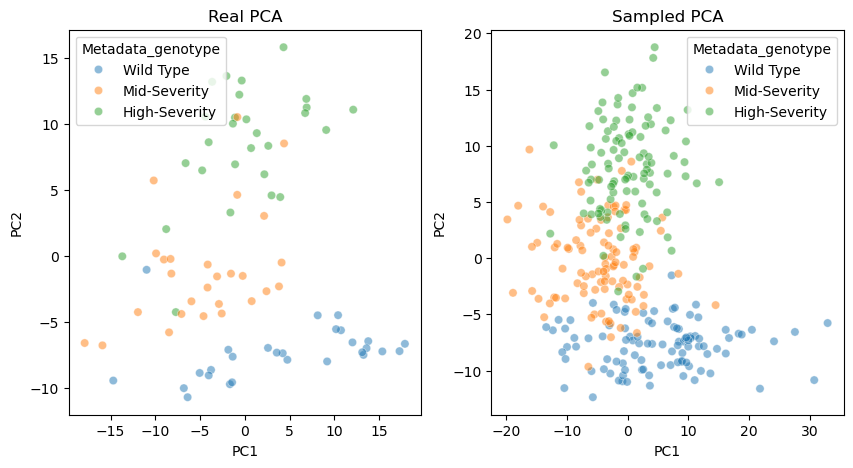

In [16]:
# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=mean_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()